In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.stats import pearsonr, spearmanr

long_table = pd.read_csv(
    '../code/SplicingAnalysis/CombinedJuncTables/YRI.tsv.gz', sep='\t')


In [2]:
exons = pd.read_csv('../../EVENT_INFO-hg38.tab.gz', sep='\t')[['EVENT', 'COMPLEX', 'CO_C1', 'CO_A', 'CO_C2', 'LE_n']].dropna()
exons.head()

,EVENT,COMPLEX,CO_C1,CO_A,CO_C2,LE_n
0,HsaEX0000026,A_S,chr12:120209839-120209934,chr12:120210930-120211106,chr12:120212375-120212919,177
1,HsaEX0000056,A_C3,chr14:28832006-28832060,chr14:28837253-28837330,chr14:28841804-28842082,78
2,HsaEX0000064,A_C1,chr14:101559800-101560025,chr14:101558633-101558834,chr14:101557754-101557819,202
3,HsaEX0000080,A_C3,chr14:38948178-38948239,chr14:38916782-38916882,chr14:38890741-38890798,101
4,HsaEX0000090,A_C3,chr15:69403845-69414220,chr15:69400973-69401027,chr15:69396904-69397748,55


In [3]:
# Remove microexons, intron retention, and Alt 3' or 5' events
exons = exons.loc[~exons.COMPLEX.isin(['MIC_S', 'IR', 'Alt3', 'Alt5', 'MIC-M'])]

exon = exons.EVENT
LE = exons.LE_n
c1 = exons.CO_C1.str.split('-', expand=True)
chrom = c1[0].str.split(':', expand=True)[0]
donor_c1 = c1[1].astype(int)

ca = exons.CO_A.str.split('-', expand=True)
receptor_c1 = ca[0].str.split(':', expand=True)[1].astype(int) - 1
donor_c2 = ca[1].astype(int)

c2 = exons.CO_C2.str.split('-', expand=True)
receptor_c2 = c2[0].str.split(':', expand=True)[1].astype(int) - 1

exon = exons.EVENT
LE = exons.LE_n
c1 = exons.CO_C1.str.split('-', expand=True)
chrom = c1[0].str.split(':', expand=True)[0]
donor_c1 = c1[1].astype(int)

ca = exons.CO_A.str.split('-', expand=True)
receptor_c1 = ca[0].str.split(':', expand=True)[1].astype(int) - 1
donor_c2 = ca[1].astype(int)

c2 = exons.CO_C2.str.split('-', expand=True)
receptor_c2 = c2[0].str.split(':', expand=True)[1].astype(int) - 1



In [4]:
impact = pd.read_csv('../../PROT_IMPACT-hg38-v3.tab.gz', sep='\t')
impact.index = impact.EventID
impact.head()

,EventID,ONTO
EventID,,
HsaEX0000026,HsaEX0000026,NonCoding
HsaEX0000056,HsaEX0000056,NonCoding
HsaEX0000064,HsaEX0000064,NonCoding
HsaEX0000080,HsaEX0000080,NonCoding
HsaEX0000090,HsaEX0000090,NonCoding


In [5]:
df = pd.DataFrame()
df['event'] = list(exon)
df['chrom'] = list(chrom)
df['donor_c1'] = list(donor_c1)
df['receptor_c1'] = list(receptor_c1)
df['donor_c2'] = list(donor_c2)
df['receptor_c2'] = list(receptor_c2)
df['LE_n'] = list(LE)
df = df.loc[[x[:5]=='HsaEX' for x in df.event]]
df = df.loc[df.event.isin(impact.loc[~impact.ONTO.isin(['NonCoding', "5' UTR", "3' UTR"])].index)]
df.index = df.event


In [6]:
def merge_and_pivot(long_table_subset, df, donor, receptor):
    c = df.merge(long_table_subset, 
         left_on=['chrom', donor, receptor], right_on=['chrom', 'start', 'stop'])
    c = pd.pivot_table(c, values='Count', index='event', columns='IndID', fill_value=0)
    return c

def get_PSI(long_table, df, dataset):
    '''
    Function for getting PSI of cassette exons.
    long_table contains junction read counts for every junction in every sample, in every assay or dataset.
    df annotation of cassette exons.
    dataset which group of samples to use from the long_table.
    '''
    
    long_table_subset = long_table.loc[long_table.Dataset==dataset]
    
    c1 = merge_and_pivot(long_table_subset, df, 'donor_c1', 'receptor_c1')
    c2 = merge_and_pivot(long_table_subset, df, 'donor_c2', 'receptor_c2')
    ca = merge_and_pivot(long_table_subset, df, 'donor_c1', 'receptor_c2')
#     df.merge(long_table.loc[long_table.Dataset==dataset], 
#          left_on=['chrom', 'donor_c1', 'receptor_c1'], right_on=['chrom', 'start', 'stop'])

#     c1 = pd.pivot_table(c1, values='Count', index='event', columns='IndID', fill_value=0)

#     c2 = df.merge(long_table.loc[long_table.Dataset==dataset], 
#              left_on=['chrom', 'donor_c2', 'receptor_c2'], right_on=['chrom', 'start', 'stop'])

#     c2 = pd.pivot_table(c2, values='Count', index='event', columns='IndID', fill_value=0)


#     ca = df.merge(long_table.loc[long_table.Dataset==dataset], 
#              left_on=['chrom', 'donor_c1', 'receptor_c2'], right_on=['chrom', 'start', 'stop'])

#     ca = pd.pivot_table(ca, values='Count', index='event', columns='IndID', fill_value=0)


    all_index = c1.index.union(c2.index).union(ca.index)

    c1 = c1.reindex(all_index).fillna(0)
    c2 = c2.reindex(all_index).fillna(0)
    ca = ca.reindex(all_index).fillna(0)

    filtered_index = all_index[(c1+c2+ca).sum(axis=1) > 10]

    c1 = c1.loc[filtered_index]
    c2 = c2.loc[filtered_index]
    ca = ca.loc[filtered_index]

    c1_mean = (c1/(c1+c2+ca)).mean(axis=1)
    c2_mean = (c2/(c1+c2+ca)).mean(axis=1)

    filtered_index = filtered_index[np.abs(c1_mean - c2_mean) <= 0.333]

    c1 = c1.loc[filtered_index]
    c2 = c2.loc[filtered_index]
    ca = ca.loc[filtered_index]
    PSI = (c1+c2)/(c1+c2+(2*ca))
    
    PSI.loc[PSI.isna().mean(axis=1) < 0.5]
    
    return PSI



In [7]:
chRNA = get_PSI(long_table, df, 'chRNA.Expression.Splicing')
polyA = get_PSI(long_table, df, 'Expression.Splicing')

chRNA.head()

IndID,NA18486,NA18497,NA18498,NA18499,NA18502,NA18504,NA18505,NA18507,NA18508,NA18510,...,NA19209,NA19210,NA19213,NA19214,NA19225,NA19236,NA19238,NA19239,NA19247,NA19257
event,,,,,,,,,,,,,,,,,,,,,
HsaEX0000029,1.000000,0.230769,0.090909,0.000000,0.000000,0.600000,0.241379,0.562500,0.166667,0.000000,...,0.312500,0.153846,0.250000,0.333333,0.000000,0.488372,0.272727,0.263158,0.142857,0.173913
HsaEX0000031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HsaEX0000038,0.833333,0.512195,0.743590,0.851852,0.758621,0.377778,0.828571,0.724138,0.596491,0.600000,...,0.740741,0.684211,0.466667,0.849057,0.590909,0.581395,0.675676,0.458333,0.423077,0.563636
HsaEX0000039,NaN,0.000000,NaN,0.000000,1.000000,0.000000,0.000000,0.333333,0.100000,0.090909,...,NaN,0.500000,NaN,0.000000,1.000000,0.000000,0.000000,0.333333,0.555556,0.200000
HsaEX0000114,1.000000,0.938931,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.989011,1.000000,1.000000,0.990148


In [8]:
long_table_KD = pd.read_csv(
    '../code/SplicingAnalysis/CombinedJuncTables/NMD_KD.tsv.gz', sep='\t'
)


HeLa_scr = get_PSI(long_table_KD, df, 'HeLa.scr')
HeLa_dKD = get_PSI(long_table_KD, df, 'HeLa.dKD')
HeLa_UPF1 = get_PSI(long_table_KD, df, 'HeLa.UPF1.KD')
HeLa_SMG7 = get_PSI(long_table_KD, df, 'HeLa.SMG7.KD')
HeLa_SMG6 = get_PSI(long_table_KD, df, 'HeLa.SMG6.KD')

del long_table_KD

In [9]:
def get_PSI_symmetry_slice(df, PSI, psi_low, psi_high):
    psi_cols = sorted(PSI.columns)
    pct_symmetric = []
    for col in psi_cols:
        pct_symmetric.append(((df.loc[PSI.loc[(PSI[col] >= psi_low) & (PSI[col] <= psi_high)].index, 'LE_n'] %3)==0).mean())
    return pct_symmetric

def get_PSI_symmetry(df, PSI):
    psi_list = []
    psi_list.append(get_PSI_symmetry_slice(df, PSI, 0.01, 0.05))
    psi_list.append(get_PSI_symmetry_slice(df, PSI, 0.05, 0.1))
    psi_list.append(get_PSI_symmetry_slice(df, PSI, 0.1, 0.25))
    psi_list.append(get_PSI_symmetry_slice(df, PSI, 0.25, 0.75))
    
    psi_list = np.array(psi_list).T
    return psi_list

In [10]:
df.head()

,event,chrom,donor_c1,receptor_c1,donor_c2,receptor_c2,LE_n
event,,,,,,,
HsaEX0000182,HsaEX0000182,chr4,56371643,56355181,56355423,56354704,242
HsaEX0000217,HsaEX0000217,chr9,104861800,104858521,104858698,104855565,177
HsaEX0000219,HsaEX0000219,chr9,104858698,104845476,104845569,104840278,93
HsaEX0000226,HsaEX0000226,chr9,104814475,104814117,104814231,104812573,114
HsaEX0000238,HsaEX0000238,chr17,69174394,69164963,69165083,69164073,120


In [11]:
polyA_symmetric = get_PSI_symmetry(df, polyA)
chRNA_symmetric = get_PSI_symmetry(df, chRNA)
HeLa_scr_symmetric = get_PSI_symmetry(df, HeLa_scr)
HeLa_dKD_symmetric = get_PSI_symmetry(df, HeLa_dKD)
HeLa_UPF1_symmetric = get_PSI_symmetry(df, HeLa_UPF1)

In [12]:
def get_summary_stats(x, interval = (0.05, 0.95)):
    median = np.mean(x)
    quant_10 = np.quantile(x, interval[0])
    quant_90 = np.quantile(x, interval[1])
    return median, quant_10, quant_90

def plot_summary(x, ax, i, c='blue', MarkerStyle='o', label='', interval= (0.05, 0.95)):
    median, quant_10, quant_90 = get_summary_stats(x*100, interval=interval)
    ax.plot([i, i], [quant_10, quant_90], c=c)
    ax.scatter([i], [median], c=c, marker=MarkerStyle, label=label)
    
def plot_mean(x, i_list, ax, c='blue', interval= (0.05, 0.95)):
    
    x_list = []
    for y in x:
        x_list.append(get_summary_stats(y*100, interval=interval)[0])
        
    ax.plot(i_list, x_list, c=c)

def plot_PSI(x, ax, c, label, MarkerStyle='o', interval= (0.05, 0.95)):
    plot_summary(x[0], ax, 0, c=c, label=label, MarkerStyle=MarkerStyle, interval=interval)
    plot_summary(x[1], ax, 3, c=c, MarkerStyle=MarkerStyle, interval=interval)
    plot_summary(x[2], ax, 6, c=c, MarkerStyle=MarkerStyle, interval=interval)
    plot_summary(x[3], ax, 9, c=c, MarkerStyle=MarkerStyle, interval=interval)
    plot_mean(x, [0, 3, 6, 9], ax, c=c, interval=interval)

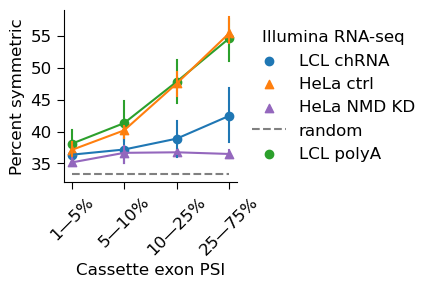

In [13]:
plt.rcParams['legend.title_fontsize'] = 12

fig, ax = plt.subplots(figsize=(2.24, 2.24))

plot_PSI(polyA_symmetric.T, ax, c='tab:green', label='LCL polyA')
plot_PSI(chRNA_symmetric.T, ax, c='tab:blue', label='LCL chRNA')
plot_PSI(HeLa_scr_symmetric.T, ax, c='tab:orange', label='HeLa ctrl', MarkerStyle='^')
plot_PSI(HeLa_dKD_symmetric.T, ax, c='tab:purple', label='HeLa NMD KD', MarkerStyle='^', interval=(0, 1))

ax.plot([0, 9], [33.33, 33.33], linestyle='--', c='grey', label='random')

handles, labels = fig.gca().get_legend_handles_labels()
order = [1, 2, 3, 4, 0]

ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
          loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, title='Illumina RNA-seq', fontsize=12)

# ax.legend(loc='center left', bbox_to_anchor=(1, 0.8), frameon=False, title='Illumina RNA-seq', fontsize=12)

ax.set_xticks([0, 3, 6, 9])
ax.set_xticklabels(['1—5%', '5—10%', '10—25%', '25—75%'], rotation=45, size=12)
ax.set_xlabel('Cassette exon PSI', size=12)
ax.set_ylabel('Percent symmetric', size=12)
ax.set_yticks([35, 40, 45, 50, 55])
ax.set_yticklabels(['35', '40', '45', '50', '55'], size=12)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(length=5)


# plt.savefig('/project2/yangili1/carlos_and_ben_shared/polished_plots/cassette_exons_symmetric.png', dpi=300, bbox_inches='tight')
# plt.savefig('/project2/yangili1/carlos_and_ben_shared/polished_plots/cassette_exons_symmetric.pdf', bbox_inches='tight')

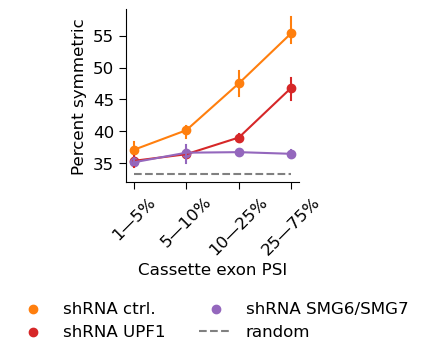

In [14]:
plt.rcParams['legend.title_fontsize'] = 12

fig, ax = plt.subplots(figsize=(2.24, 2.24))

# plot_PSI(polyA_symmetric.T, ax, c='tab:green', label='Steady state RNA')
# plot_PSI(chRNA_symmetric.T, ax, c='tab:blue', label='Nascent RNA')
plot_PSI(HeLa_scr_symmetric.T, ax, c='tab:orange', label='shRNA ctrl.', MarkerStyle='o')
plot_PSI(HeLa_UPF1_symmetric.T, ax, c='tab:red', label='shRNA UPF1', MarkerStyle='o', interval=(0, 1))
plot_PSI(HeLa_dKD_symmetric.T, ax, c='tab:purple', label='shRNA SMG6/SMG7', MarkerStyle='o', interval=(0, 1))

ax.plot([0, 9], [33.33, 33.33], linestyle='--', c='grey', label='random')

handles, labels = fig.gca().get_legend_handles_labels()
order = [1, 2, 3, 4, 0]

ax.legend(loc='lower center', bbox_to_anchor=(0.5, -1), ncols=2, frameon=False, fontsize=12)

# ax.legend(loc='center left', bbox_to_anchor=(1, 0.8), frameon=False, title='Illumina RNA-seq', fontsize=12)

ax.set_xticks([0, 3, 6, 9])
ax.set_xticklabels(['1—5%', '5—10%', '10—25%', '25—75%'], rotation=45, size=12)
ax.set_xlabel('Cassette exon PSI', size=12)
ax.set_ylabel('Percent symmetric', size=12)
ax.set_yticks([35, 40, 45, 50, 55])
ax.set_yticklabels(['35', '40', '45', '50', '55'], size=12)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(length=5)


# plt.savefig('/project2/yangili1/carlos_and_ben_shared/polished_plots/cassette_exons_symmetric_HeLa_only.png', dpi=300, bbox_inches='tight')
# plt.savefig('/project2/yangili1/carlos_and_ben_shared/polished_plots/cassette_exons_symmetric_HeLa_only.pdf', bbox_inches='tight')

In [15]:
def get_gm_list(gm):
    ctrl1_list = []
    ctrl1_list.append(((gm.loc[(gm.PSI >= 0.01) & (gm.PSI < 0.05)].LE_n % 3) == 0).mean())
    ctrl1_list.append(((gm.loc[(gm.PSI >= 0.05) & (gm.PSI < 0.1)].LE_n % 3) == 0).mean())
    ctrl1_list.append(((gm.loc[(gm.PSI >= 0.1) & (gm.PSI < 0.25)].LE_n % 3) == 0).mean())
    ctrl1_list.append(((gm.loc[(gm.PSI >= 0.25) & (gm.PSI < 0.75)].LE_n % 3) == 0).mean())
    
    return ctrl1_list

ctrl1 = pd.read_csv('../code/LongReads/Exons/CTRL1_shRNA.SAMEA8691110.cassette_exons.tab.gz', sep='\t', index_col=0)
ctrl1_list = get_gm_list(ctrl1)

ctrl2 = pd.read_csv('../code/LongReads/Exons/CTRL2_shRNA.SAMEA8691111.cassette_exons.tab.gz', sep='\t', index_col=0)
ctrl2_list = get_gm_list(ctrl2)

NMD_KD = pd.read_csv('../code/LongReads/Exons/SMG6_SMG7_shRNA.SAMEA8691113.cassette_exons.tab.gz', sep='\t', index_col=0)
NMD_KD_list = get_gm_list(NMD_KD)

chRNA3 = pd.read_csv('../code/LongReads/Exons/K562_4sUchr_ONT_3.SAMN10505967.cassette_exons.tab.gz', sep='\t', index_col=0)
chRNA3_list = get_gm_list(chRNA3)

chRNA4 = pd.read_csv('../code/LongReads/Exons/K562_4sUchr_ONT_4.SAMN12726878.cassette_exons.tab.gz', sep='\t', index_col=0)
chRNA4_list = get_gm_list(chRNA4)

chRNA5a = pd.read_csv('../code/LongReads/Exons/K562_4sUchr_ONT_5a.SAMN12726877.cassette_exons.tab.gz', sep='\t', index_col=0)
chRNA5a_list = get_gm_list(chRNA5a)

chRNA5b = pd.read_csv('../code/LongReads/Exons/K562_4sUchr_ONT_5b.SAMN12726876.cassette_exons.tab.gz', sep='\t', index_col=0)
chRNA5b_list = get_gm_list(chRNA5b)

upf1 = pd.read_csv('../code/LongReads/Exons/UPF1_shRNA.SAMEA8691115.cassette_exons.tab.gz', sep='\t', index_col=0)
upf1_list = get_gm_list(upf1)

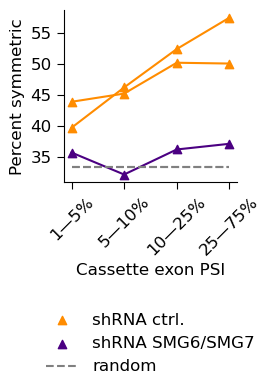

In [16]:
fig, ax = plt.subplots(figsize=(2.24, 2.24))

ax.plot([0, 3, 6, 9], np.array(ctrl1_list)*100, c='darkorange')
ax.scatter([0, 3, 6, 9], np.array(ctrl1_list)*100, c='darkorange', zorder=10, label='shRNA ctrl.', marker='^')
ax.plot([0, 3, 6, 9], np.array(ctrl2_list)*100, c='darkorange')
ax.scatter([0, 3, 6, 9], np.array(ctrl2_list)*100, c='darkorange', zorder=10, marker='^')
ax.plot([0, 3, 6, 9], np.array(NMD_KD_list)*100, c='indigo')
ax.scatter([0, 3, 6, 9], np.array(NMD_KD_list)*100, c='indigo', zorder=10, label='shRNA SMG6/SMG7', marker='^')

ax.plot([0, 9], [33.33, 33.33], linestyle='--', c='grey', label='random')

handles, labels = fig.gca().get_legend_handles_labels()
order = [0, 1, 2]

ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
          loc='lower center', bbox_to_anchor=(0.5, -1.2), frameon=False, fontsize=12)

# ax.legend(loc='lower center', bbox_to_anchor=(0.5, -1.2), frameon=False, fontsize=12)




ax.set_xlabel('Cassette exon PSI', size=12)
ax.set_ylabel('Percent symmetric', size=12)
ax.set_yticks([35, 40, 45, 50, 55])
ax.set_yticklabels(['35', '40', '45', '50', '55'], size=12)

ax.set_xticks([0, 3, 6, 9])
ax.set_xticklabels(['1—5%', '5—10%', '10—25%', '25—75%'], rotation=45, size=12)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(length=5)

ax.plot([0, 9], [33.33, 33.33], linestyle='--', c='grey')


# plt.savefig('/project2/yangili1/carlos_and_ben_shared/polished_plots/cassette_exons_symmetric.long_reads.png', dpi=300, bbox_inches='tight')
# plt.savefig('/project2/yangili1/carlos_and_ben_shared/polished_plots/cassette_exons_symmetric.long_reads.pdf', bbox_inches='tight')

In [17]:
intron_annot = pd.read_csv('/project2/yangili1/bjf79/ChromatinSplicingQTLs/data/IntronAnnotationsFromYang.tsv.gz', sep='\t')
intron_annot['junction'] = intron_annot[['chrom', 'start', 'end', 'strand']].astype(str).agg(':'.join, axis=1)
# long_table = pd.read_csv(
#     '/project2/yangili1/bjf79/ChromatinSplicingQTLs/code/SplicingAnalysis/CombinedJuncTables/YRI.tsv.gz', sep='\t'
# )

long_table = long_table.loc[long_table.RepNumber == '1.junc'].drop_duplicates()
long_table = long_table.loc[~((long_table.IndID == 'NA18855') & (long_table.Dataset == 'chRNA.Expression.Splicing'))]

# Adjustment needed to match the introns in Yang's annotation...
long_table.stop += 1

long_table = long_table.merge(intron_annot, left_on=['chrom', 'start', 'stop', 'strand'], 
                 right_on=['chrom', 'start', 'end', 'strand'])



del intron_annot
expressed_genes = pd.read_csv('../code/ExpressionAnalysis/polyA/ExpressedGeneList.txt', sep ='\t',
                             names = ['chrom', 'start', 'end', 'gene', 'score', 'strand'])

In [18]:
long_table.shape

(47701031, 15)

In [19]:
def get_series_quantile(series, gene_list=None, quant=4):
    
    if not gene_list is None:
        series = series.loc[gene_list].dropna()
    
    q = 1/quant
    
    seriesQ_list = []
    
    for i in range(quant):
        Qi = series.quantile(q*i)
        Qi2 = series.quantile(q*(i+1))
        if i == 0:
            Qi -= 1
        if i == (quant-1):
            Qi2 += 1
        seriesQi = series.loc[(series >= Qi) & (series < Qi2)].index
        
        seriesQ_list.append(seriesQi)
        
    return seriesQ_list

RPKM = pd.read_csv(
    '../code/QTLs/QTLTools/chRNA.Expression.Splicing/OnlyFirstRepsUnstandardized.qqnorm.bed.gz', sep='\t',
                   index_col=3)

YRI_samples = RPKM.columns[5:]

# RPKM_median = RPKM[
#     [x for x in pd.Index(cluster_table.IndID.unique()).intersection(RPKM.columns) if x !=  'NA18855']
#                   ].median(axis=1)
# rpkm_1, rpkm_2, rpkm_3, rpkm_4 = get_series_quantile(RPKM_median)


# lt1 = long_table.loc[long_table.gene.isin(rpkm_1)]
# df_rpkm1, order = longtable_to_boxplot(lt1)

# lt2 = long_table.loc[long_table.gene.isin(rpkm_2)]
# df_rpkm2, order = longtable_to_boxplot(lt2)

# lt3 = long_table.loc[long_table.gene.isin(rpkm_3)]
# df_rpkm3, order = longtable_to_boxplot(lt3)

# lt4 = long_table.loc[long_table.gene.isin(rpkm_4)]
# df_rpkm4, order = longtable_to_boxplot(lt4)

# rpkm_df = pd.DataFrame()
# unprod_juncs = list(df_rpkm1.loc[df_rpkm1.assay=='chRNA'].Unproductive_juncs)
# unprod_juncs += list(df_rpkm2.loc[df_rpkm2.assay=='chRNA'].Unproductive_juncs)
# unprod_juncs += list(df_rpkm3.loc[df_rpkm3.assay=='chRNA'].Unproductive_juncs)
# unprod_juncs += list(df_rpkm4.loc[df_rpkm4.assay=='chRNA'].Unproductive_juncs)

# rpkm_df['unprod_juncs'] = unprod_juncs
# rpkm_df['rpkm_quartile'] = ['Q1']*86 + ['Q2']*86 + ['Q3']*86 + ['Q4']*86

In [20]:
NMD_annot = ['UnannotatedJunc_UnproductiveCodingGene', 'AnnotatedJunc_UnproductiveCodingGene']
pc_annot = ['UnannotatedJunc_ProductiveCodingGene', 'AnnotatedJunc_ProductiveCodingGene']

NMD_counts = long_table.loc[
    (long_table.Dataset=='chRNA.Expression.Splicing') &  long_table.SuperAnnotation.isin(NMD_annot)
].groupby(['gene', 'IndID']).Count.sum().reset_index().pivot_table(index='gene', columns='IndID', values='Count').fillna(0)

pc_counts = long_table.loc[
    (long_table.Dataset=='chRNA.Expression.Splicing') &  long_table.SuperAnnotation.isin(pc_annot)
].groupby(['gene', 'IndID']).Count.sum().reset_index().pivot_table(index='gene', columns='IndID', values='Count').fillna(0)

genes_index = NMD_counts.index.intersection(pc_counts.index)

chRNA_RPKM = pd.read_csv(
    '../code/QTLs/QTLTools/chRNA.Expression.Splicing/OnlyFirstRepsUnstandardized.qqnorm.bed.gz', sep='\t',
                   index_col=3)

ml30_RPKM = pd.read_csv(
    '../code/QTLs/QTLTools/MetabolicLabelled.30min/OnlyFirstRepsUnstandardized.qqnorm.bed.gz', sep='\t',
                   index_col=3)

YRI_samples = RPKM.columns[5:]
polyA_RPKM = pd.read_csv(
    '../code/QTLs/QTLTools/Expression.Splicing.Subset_YRI/OnlyFirstRepsUnstandardized.qqnorm.bed.gz', sep='\t',
                   index_col=3)

YRI_samples = RPKM.columns[5:]


In [21]:
polyA_log2RPKM = polyA_RPKM[polyA_RPKM.columns[5:]].median(axis=1)
ml30_log2RPKM = ml30_RPKM[ml30_RPKM.columns[5:]].median(axis=1)
chRNA_log2RPKM = chRNA_RPKM[chRNA_RPKM.columns[5:]].median(axis=1)


polyA_log2RPKM.index = [x.split('.')[0] for x in polyA_log2RPKM.index]
ml30_log2RPKM.index = [x.split('.')[0] for x in ml30_log2RPKM.index]
chRNA_log2RPKM.index = [x.split('.')[0] for x in chRNA_log2RPKM.index]
NMD_counts.index = [x.split('.')[0] for x in NMD_counts.index]
pc_counts.index = [x.split('.')[0] for x in pc_counts.index]


chRNA_genes = chRNA_log2RPKM.loc[chRNA_log2RPKM > -10].index
polyA_genes = polyA_log2RPKM.loc[polyA_log2RPKM > -10].index
genes_index = chRNA_genes.intersection(polyA_genes).intersection(NMD_counts.index).intersection(pc_counts.index)


total_counts = NMD_counts.loc[genes_index] + pc_counts.loc[genes_index]
NMD_percent = NMD_counts.loc[genes_index]/total_counts

chRNA_juncs_NMD_ratio = np.log2(NMD_percent.loc[genes_index].mean(axis=1))




NMD_ratio_quant_all_genes = get_series_quantile(chRNA_juncs_NMD_ratio, quant=5)
chRNA_polyA_log2_difference = chRNA_log2RPKM.loc[genes_index] - polyA_log2RPKM.loc[genes_index]
ml30_polyA_log2_difference = ml30_log2RPKM.loc[genes_index] - polyA_log2RPKM.loc[genes_index]

In [22]:
chRNA_genes = chRNA_log2RPKM.loc[chRNA_log2RPKM > -10].index
polyA_genes = polyA_log2RPKM.loc[polyA_log2RPKM > -10].index
genes_index = chRNA_genes.intersection(genes_index).intersection(polyA_genes)

total_counts = NMD_counts.loc[genes_index] + pc_counts.loc[genes_index]
NMD_percent = NMD_counts.loc[genes_index]/total_counts


In [23]:
def get_cluster_pct_NMD(clu, df_clu):
    pct_NMD = []
    for df in df_clu.loc[df_clu.cluster.isin(clu)].groupby('cluster'):
        if df[1].isNMD.all():
            pct_NMD.append(1)
        elif not df[1].isNMD.any():
            pct_NMD.append(0)
        elif df[1][chRNA_samples].sum().sum() > 0:
            NMD_counts = df[1].loc[df[1].isNMD][chRNA_samples].sum().sum()
            total_counts = df[1][chRNA_samples].sum().sum()
            pct_NMD.append(NMD_counts/total_counts)
    return pct_NMD

def plot_cumulative(X, ax=None, linewidth=1, **kwargs):
    X = np.array(X)
    
    # sort X
    X = sorted(X)
    # define Y as the cummulative fraction of X
    Y = np.cumsum([True]*len(X))/len(X)
    if ax:
        ax.plot(X, Y, linewidth=linewidth, **kwargs)
    else:
        plt.plot(X, Y, linewidth=linewidth, **kwargs)
        
        

def plot_cumulative_quantiles(X, quantile_list, color_list, label_list = None,
                               method='median', ax=None, plot_legend = False, norm_to_Q1 = False, linewidth=1,
                               **kwargs):
    for i in range(len(quantile_list)):
        Qi = quantile_list[i]
        color = color_list[i]
        
        if label_list is None:
            label = 'Q' + str(i+1)
        else:
            label = label_list[i]
            
        X_to_plot = np.array(X.loc[Qi])
            
        if norm_to_Q1:
            if i == 0:
                Q1_ = X_to_plot
                continue
            else:
                X_to_plot = X_to_plot/Q1_

        plot_cumulative(X_to_plot, c=color, ax=ax, label=label, linewidth=linewidth)
            
        
                
    if ax:
        if plot_legend:
            if 'legend_title' in kwargs:
                ax.legend(title = kwargs['legend_title'], frameon=False, 
                          loc='center left', bbox_to_anchor=(1, 0.5))
            else:
                ax.legend(frameon=False,
                         loc='center left', bbox_to_anchor=(1, 0.5))
        if 'xlim' in kwargs:
            ax.set_xlim(kwargs['xlim'])
        if 'ylim' in kwargs:
            ax.set_ylim(kwargs['ylim'])
        if 'xticks' in kwargs:
            ax.set_xticks(kwargs['xticks'])
        if 'xticklabels' in kwargs:
            ax.set_xticklabels(kwargs['xticklabels'])
        if 'yticks' in kwargs:
            ax.set_yticks(kwargs['yticks'])
        if 'yticklabels' in kwargs:
            ax.set_yticklabels(kwargs['yticklabels'])
        ax.spines['left'].set_linewidth(2)
        ax.spines['bottom'].set_linewidth(2)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        #ax.tick_params(size=4, width=2, labelsize=kwargs['fontsize'])
        if 'vertical_line_at' in kwargs:
            ax.plot([kwargs['vertical_line_at'], kwargs['vertical_line_at']], 
                    [0, 1], linestyle='--', c='gray')
        if 'xlabel' in kwargs:
            ax.set_xlabel(kwargs['xlabel'], fontsize=kwargs['fontsize'])
        if 'ylabel' in kwargs:
            ax.set_ylabel(kwargs['ylabel'], fontsize=kwargs['fontsize'])
        if 'title' in kwargs:
            ax.set_title(kwargs['title'], fontsize=kwargs['fontsize'])


In [24]:
# We get H3K36ME3 coverage over the gene body
h3k36me3_logRPKM = pd.read_csv(
    '../code/QTLs/QTLTools/H3K36ME3/OnlyFirstRepsUnstandardized.qqnorm.bed.gz', sep='\t',
                   index_col=3)

h3k36me3_logRPKM = h3k36me3_logRPKM[h3k36me3_logRPKM.columns[5:]]
h3k36me3_logRPKM.index = [x.split('.')[0] for x in h3k36me3_logRPKM.index]

# Get log2 fold difference
h3k36me3_log2RPKM = h3k36me3_logRPKM.loc[genes_index]
h3k36me3_polyA_log2_difference = h3k36me3_log2RPKM.median(axis=1) - polyA_log2RPKM


# For H3K4ME3, it's a bit trickier. We get the CPM of the peaks that are close (within 2000 bp) of
# a TSS for each gene

H3K4ME3_TSS = pd.read_csv('../code/featureCounts/H3K4ME3/Counts.txt',
                                 sep='\t', skiprows = 1)
H3K4ME3_names = [x.split('ME3/')[1].split('.1')[0] for x in H3K4ME3_TSS.columns if ('Alignments' in x)]

H3K4ME3 = pd.read_csv('../code/QTLs/QTLTools/H3K4ME3/CountsPeaksAtTSS.bed.gz',#'../../H3K4ME3.TSS.PeakCounts.bed.gz', 
                      sep='\t',
                     names = ['chrom', 'start', 'end', 'transcript_id', 'ensembl_id', 'strand',
                             'gene_id', 'chrom_', 'start_', 'end_', 'peak_id', 'peak_len',
                             'strand_'] + H3K4ME3_names + ['overlap_len'])
                     
H3K4ME3_samples = [x for x in H3K4ME3.columns if ((x[:2] == 'NA') and (x[-4:] != '.bam'))]
H3K4ME3 = H3K4ME3.groupby(['ensembl_id', 'peak_id']).max().reset_index()
H3K4ME3_counts = H3K4ME3.groupby('ensembl_id')[H3K4ME3_samples].sum()
h3k4me3_CPM = H3K4ME3_counts.divide(H3K4ME3_counts.sum(axis=0), axis=1)*1e6

h3k4me3_CPM = h3k4me3_CPM[H3K4ME3_samples]
h3k4me3_CPM = h3k4me3_CPM.loc[h3k4me3_CPM.median(axis=1) > 0]
h3k4me3_CPM.index = [x.split('.')[0] for x in h3k4me3_CPM.index]

h3k4me3_idx = genes_index.intersection(h3k4me3_CPM.index)
h3k4me3_log2RPKM = np.log2(h3k4me3_CPM.loc[h3k4me3_idx]) 
h3k4me3_log2RPKM = h3k4me3_log2RPKM.loc[h3k4me3_log2RPKM.median(axis=1) > -1e100]
h3k4me3_idx = h3k4me3_log2RPKM.index
h3k4me3_polyA_log2_difference = h3k4me3_log2RPKM.median(axis=1) - polyA_log2RPKM.loc[h3k4me3_idx]




H3K27AC_TSS = pd.read_csv('../code/featureCounts/H3K27AC/Counts.txt',
                                 sep='\t', skiprows = 1)
H3K27AC_names = [x.split('27AC/')[1].split('.1')[0] for x in H3K27AC_TSS.columns if ('Alignments' in x)]

H3K27AC = pd.read_csv('../code/QTLs/QTLTools/H3K27AC/CountsPeaksAtTSS.bed.gz',#'../../H3K27AC.TSS.PeakCounts.bed.gz', 
                      sep='\t',
                     names = ['chrom', 'start', 'end', 'transcript_id', 'ensembl_id', 'strand',
                             'gene_id', 'chrom_', 'start_', 'end_', 'peak_id', 'peak_len',
                             'strand_'] + H3K27AC_names + ['overlap_len'])
                     
H3K27AC_samples = [x for x in H3K27AC.columns if ((x[:2] == 'NA') and (x[-4:] != '.bam'))]
H3K27AC = H3K27AC.groupby(['ensembl_id', 'peak_id']).max().reset_index()
H3K27AC_counts = H3K27AC.groupby('ensembl_id')[H3K27AC_samples].sum()
h3k27ac_CPM = H3K27AC_counts.divide(H3K27AC_counts.sum(axis=0), axis=1)*1e6

h3k27ac_CPM = h3k27ac_CPM[H3K27AC_samples]

h3k27ac_CPM = h3k27ac_CPM.loc[h3k27ac_CPM.median(axis=1) > 0]
h3k27ac_CPM.index = [x.split('.')[0] for x in h3k27ac_CPM.index]

h3k27ac_idx = genes_index.intersection(h3k27ac_CPM.index)
h3k27ac_log2RPKM = np.log2(h3k27ac_CPM.loc[h3k27ac_idx]) 
h3k27ac_log2RPKM = h3k27ac_log2RPKM.loc[h3k27ac_log2RPKM.median(axis=1) > -1e100]
h3k27ac_idx = h3k27ac_log2RPKM.index
h3k27ac_polyA_log2_difference = h3k27ac_log2RPKM.median(axis=1) - polyA_log2RPKM.loc[h3k27ac_idx]



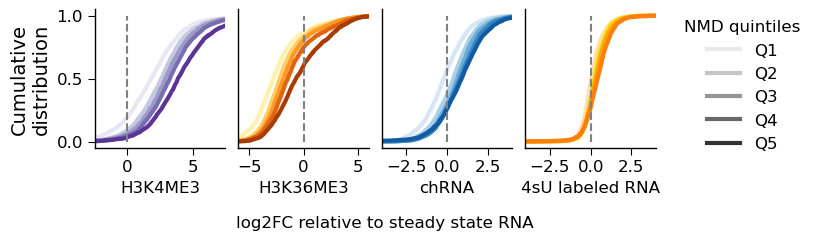

In [25]:
plt.rcParams['legend.title_fontsize'] = 12

h3k4me3_idx = h3k4me3_idx.intersection(chRNA_juncs_NMD_ratio.index)
h3k27ac_idx = h3k27ac_idx.intersection(chRNA_juncs_NMD_ratio.index)
h3k36me3_idx = h3k36me3_polyA_log2_difference.dropna().index.intersection(chRNA_juncs_NMD_ratio.index)

fig, ax = plt.subplots(nrows=1, ncols=4, gridspec_kw={'hspace': 0.5, 'wspace': 0.1}, figsize=(7.24, 1.8))

    
NMD_ratio_quant_all_genes = get_series_quantile(chRNA_juncs_NMD_ratio, quant=5)
NMD_ratio_quant_all_h3k4me3 = get_series_quantile(chRNA_juncs_NMD_ratio.loc[h3k4me3_idx], quant=5)
NMD_ratio_quant_all_h3k36me3 = get_series_quantile(chRNA_juncs_NMD_ratio.loc[h3k36me3_idx], quant=5)
NMD_ratio_quant_all_h3k27ac = get_series_quantile(chRNA_juncs_NMD_ratio.loc[h3k27ac_idx], quant=5)

plot_cumulative_quantiles(h3k4me3_polyA_log2_difference.loc[h3k4me3_idx], NMD_ratio_quant_all_h3k4me3, 
                    sns.color_palette("Purples", 5), xlim=[-2.5, 7.5], 
                          ax=ax[0],
                          xlabel = 'H3K4ME3',
                          ylabel='cumulative\ndistribution',
                          vertical_line_at = 0,
                           label_list = [None, None, None, None, None],
                   legend_title = '%NMD quintiles', fontsize=12, linewidth=3)

plot_cumulative_quantiles(h3k36me3_polyA_log2_difference.loc[h3k36me3_idx], NMD_ratio_quant_all_h3k36me3, 
                  sns.color_palette("YlOrBr", 5),
                          # ['peachpuff', 'sandybrown', 'chocolate', 'sienna', 'tab:brown'], 
                          xlim=[-6,6], 
                          ax=ax[1],
                          vertical_line_at = 0,
                           label_list = [None, None, None, None, None],
                   xlabel = 'H3K36ME3', legend_title = '%NMD quintiles', fontsize=12, linewidth=3)

plot_cumulative_quantiles(chRNA_polyA_log2_difference, NMD_ratio_quant_all_genes, 
                                  sns.color_palette("Blues", 5),
#                           ['deepskyblue', '#1e7cff', 'blue', 'mediumblue', 'navy'], 
                                   ax=ax[2], label_list = [None, None, None, None, None],
                                   xlabel='chRNA',
                                   vertical_line_at = 0, 
                          xlim=[-4, 4],
                                   fontsize=12, method='', linewidth=3)

plot_cumulative_quantiles(ml30_polyA_log2_difference, NMD_ratio_quant_all_genes, 
#                                    sns.color_palette("Oranges", 5),
                          ['navajowhite', 'khaki', 'gold', 'orange', 'tab:orange'], 
                                   ax=ax[3], label_list = [None, None, None, None, None],
                                   xlabel='4sU labeled RNA',
                                   vertical_line_at = 0, 
                          xlim=[-4, 4],
                                   fontsize=12, method='', linewidth=3)

ax[1].set_yticks([])
ax[2].set_yticks([])
ax[3].set_yticks([])

color_list = sns.color_palette("Greys", 5)
for i in range(5):
    ax[3].plot([-50], [0.5], c = color_list[i], label = 'Q' + str(i+1), linewidth=3)

ax[3].legend(title = 'NMD quintiles', frameon=False, 
                          loc='center left', bbox_to_anchor=(1.1, 0.45), fontsize=12)

# ax[0].tick_params(length=5, labelsize=12)
# ax[1].tick_params(length=5, labelsize=12)
# ax[2].tick_params(length=5, labelsize=12)
# ax[3].tick_params(length=5, labelsize=12)

ax[0].set_ylabel('Cumulative\ndistribution',size=14)

for ax_ in ax:
    ax_.spines['left'].set_linewidth(1)
    ax_.spines['bottom'].set_linewidth(1)
    ax_.tick_params(length=5, labelsize=12)
    
shared_ax = fig.add_subplot(111, frame_on=False)
shared_ax.set_position([0.1, -0.1, 0.85, 0.03])  # Adjust the position [left, bottom, width, height]
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
shared_ax.set_xlabel("log2FC relative to steady state RNA", size=12)

figdir = '/project2/yangili1/carlos_and_ben_shared/polished_plots/'

# plt.savefig(figdir + 'Fig1.coverage_distribution.adjusted_x.pdf', dpi=300, bbox_inches='tight',)
# plt.savefig(figdir + 'Fig1.coverage_distribution.adjusted_x.png', dpi=300, bbox_inches='tight',)